In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm  # progress meter

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(os.environ.get("PWD"))  # change working directory to project directory
from src.helper.helper_sklearn_plotting import plot_feature_importances

Duplicate key in file '/Users/martin/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
diabetes = pd.read_csv('data/diabetes/diabetes_v3.csv')
print("\n".join([*diabetes.columns]))

id
cholesterol
gluc
smoke
alco
active
diabetes
age
height
weight
gender
ind
pressure_high
pressure_low


In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
diabetes.head()

,id,cholesterol,gluc,smoke,alco,active,diabetes,age,height,weight,gender,ind,pressure_high,pressure_low
0,62538,0,0,0,0,1,0,54.0000,169.0000,76.0000,1,train,100.0000,80.0000
1,49159,0,0,0,0,1,0,49.0000,165.0000,65.0000,0,train,120.0000,82.0000
2,60683,0,0,0,0,1,0,60.1699,170.0000,56.0000,0,train,120.0000,80.0000
3,42924,0,0,0,0,0,0,55.5808,169.0000,62.0000,0,train,120.0000,80.0000
4,52888,0,0,0,0,0,0,44.3890,166.0000,67.0000,0,train,120.0000,80.0000


In [4]:
diabetes.describe().drop("count")

,id,cholesterol,gluc,smoke,alco,active,diabetes,age,height,weight,gender,pressure_high,pressure_low
mean,49973.4686,0.3680,0.2273,0.0879,0.0539,0.8033,0.2508,53.1829,164.3236,74.1938,0.3480,128.5207,96.8267
std,28845.5238,0.6812,0.5733,0.2832,0.2258,0.3975,0.4335,6.7691,8.2107,14.6389,0.4763,138.6072,190.8739
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,29.5836,55.0000,10.0000,0.0000,1.0000,0.0000
25%,25027.2500,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,48.2856,159.0000,64.0000,0.0000,120.0000,80.0000
50%,50004.5000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,53.9644,165.0000,71.0000,0.0000,120.0000,80.0000
75%,74876.7500,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,58.3342,170.0000,82.0000,1.0000,140.0000,90.0000
max,99999.0000,2.0000,2.0000,1.0000,1.0000,1.0000,1.0000,64.9342,250.0000,200.0000,1.0000,16020.0000,11000.0000


In [5]:
print(f"{diabetes.shape}")

(67682, 14)


In [6]:
print(diabetes.groupby('diabetes').size())

diabetes
0    50706
1    16976
dtype: int64


<AxesSubplot:xlabel='diabetes', ylabel='count'>

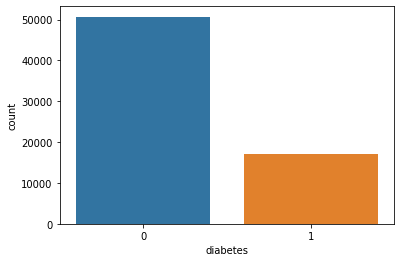

In [7]:
from seaborn import countplot
countplot(x="diabetes", data=diabetes, label="Count")

In [8]:
diabetes.describe().T[["min", "max"]]

,min,max
id,0.0000,99999.0000
cholesterol,0.0000,2.0000
gluc,0.0000,2.0000
smoke,0.0000,1.0000
alco,0.0000,1.0000
active,0.0000,1.0000
diabetes,0.0000,1.0000
age,29.5836,64.9342
height,55.0000,250.0000
weight,10.0000,200.0000


The values of pressure_high, pressure_low, and height seem to exhibit outliers. Let's see what we can do...

## Detect and remove outliers 

Value for blood pressure below 10 and above 500 are clearly wrong. 
The values for height below 100cm seem also false. 
They should be removed before calculating any Z-score or any other outlier statistic.

In [9]:
diabetes_cleaned = diabetes[diabetes.pressure_low > 10]
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned.pressure_low < 500]
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned.pressure_high > 20]
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned.pressure_high < 500]
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned.height > 100]

In [10]:
from scipy import stats
thres = 2.326 * 4  # 99% quantile of zscore is 2.326
z_score = stats.zscore(diabetes_cleaned.drop(['id', 'ind', 'diabetes'], axis=1))
'''
Outliers are observations (rows) that have
an abnormal z_score (negative or positive) 
in at least one feature.
'''

outlier = (np.abs(z_score) >= thres).any(axis=1)
diabetes_cleaned[outlier]  # these will be removed

,id,cholesterol,gluc,smoke,alco,active,diabetes,age,height,weight,gender,ind,pressure_high,pressure_low
11280,54282,1,1,0,0,1,1,59.6438,161.0000,84.0000,0,train,196.0000,182.0000
14408,68825,2,2,0,1,1,1,52.4274,164.0000,98.0000,0,train,95.0000,180.0000
20319,28449,0,0,0,0,0,1,62.5123,160.0000,88.0000,0,train,150.0000,180.0000
21022,9223,2,0,0,0,1,1,58.1370,250.0000,86.0000,0,train,140.0000,100.0000
21476,58349,0,2,0,0,1,1,54.2630,162.0000,67.0000,0,train,401.0000,80.0000
30259,53070,0,0,0,0,0,1,51.4630,175.0000,75.0000,1,train,150.0000,180.0000
32677,70400,1,1,0,1,1,1,60.3973,157.0000,86.0000,0,train,170.0000,190.0000
47553,62861,0,0,0,0,0,1,62.0603,163.0000,70.0000,1,train,200.0000,180.0000
65570,91264,0,0,0,0,1,1,44.0000,164.0000,69.0000,0,test,130.0000,190.0000


In [11]:
diabetes_cleaned = diabetes_cleaned[outlier == False]
diabetes_cleaned.describe().T[["min", "max"]]

,min,max
id,0.0000,99999.0000
cholesterol,0.0000,2.0000
gluc,0.0000,2.0000
smoke,0.0000,1.0000
alco,0.0000,1.0000
active,0.0000,1.0000
diabetes,0.0000,1.0000
age,29.5836,64.9342
height,104.0000,207.0000
weight,11.0000,200.0000


### k-Nearest Neighbors

In [12]:
features = [
    'cholesterol', 
    'gluc', 
    'smoke', 
    'alco', 
    'active', 
    'age', 
    'height', 
    'weight', 
    'gender', 
    'pressure_high',
    'pressure_low'
]

Let's normalize the data before training the model. We normalize the test data with the feature min and feature max from the training data.

#### Train and test data

In [13]:
# Train data
X_train = diabetes_cleaned[diabetes_cleaned["ind"].eq("train")][features]
feature_min, feature_max = X_train.min(), X_train.max()

# Test data
X_test = diabetes_cleaned[diabetes_cleaned["ind"].eq("test")][features]

# Min-Max-Normalization
X_train = (X_train - feature_min)/(feature_max - feature_min)
X_test = (X_test - feature_min)/(feature_max - feature_min)

# Labels
y_train = diabetes_cleaned[diabetes_cleaned["ind"].eq("train")]["diabetes"]
y_test = diabetes_cleaned[diabetes_cleaned["ind"].eq("test")]["diabetes"]

#### Find best number of neighbors (hyperparameter)

  0%|          | 0/15 [00:00<?, ?it/s]

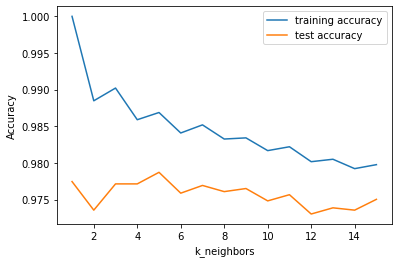

In [14]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
max_neighbors = 15
neighbors_range = range(1, max_neighbors + 1) 

for n_neighbors in tqdm(neighbors_range):
    # Build the model
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train.values, y_train)
    # Record training set accuracy
    training_accuracy.append(knn_classifier.score(X_train.values, y_train))
    # Record test set accuracy
    test_accuracy.append(knn_classifier.score(X_test.values, y_test))

plt.plot(neighbors_range, training_accuracy, label="training accuracy")
plt.plot(neighbors_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("k_neighbors")
plt.legend()
plt.savefig('results/outputs/knn_classifier_acc')
plt.show()

#### Build the final model

In [15]:
best_n_neighbors = test_accuracy.index(max(test_accuracy)) + 1

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# Build model
print(f'Build model with {best_n_neighbors} nearest neighbors')
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_classifier.fit(X_train.values, y_train)

# Compute accuracy
accuracy = {}
accuracy["train"] = knn_classifier.score(X_train.values, y_train)
accuracy["test"] = knn_classifier.score(X_test.values, y_test)
print(f'Train accuracy: {accuracy["train"]:.4f}')
print(f'Test accuracy: {accuracy["test"]:.4f}')

# Predict on test data
pred_diabetes_prob = knn_classifier.predict_proba(X_test.values)[:,1]
y_pred = pred_diabetes_prob > 0.5

Build model with 5 nearest neighbors
Train accuracy: 0.9869
Test accuracy: 0.9787


### Inspect classification result

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7194
           1       0.97      0.95      0.96      2307

    accuracy                           0.98      9501
   macro avg       0.97      0.97      0.97      9501
weighted avg       0.98      0.98      0.98      9501



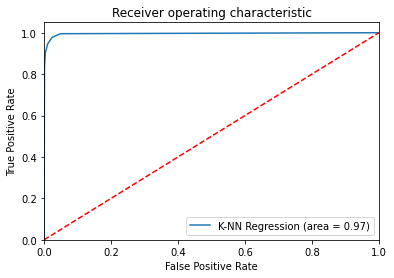

<Figure size 432x288 with 0 Axes>

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
knn_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, pred_diabetes_prob)
plt.figure()
plt.plot(fpr, tpr, label='K-NN Regression (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('results/outputs/knn_classifier_roc')
plt.show()